In [27]:
#!pip install tensorflow keras split-folders opencv-python
#!pip install split-folders

## Bibliotecas

In [42]:
import random
import cv2
import os
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE

## Preparando as Imagens

In [29]:
# Executar essa cédula pra conectar o Colab ao Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [43]:
input_folder = "bloodcells_dataset_reduced"
output_folder = "image_recognition"

In [ ]:
# Obtém os nomes das classes e ordena
class_names = sorted([d for d in os.listdir(input_folder) if os.path.isdir(os.path.join(input_folder, d))])
class_names

['basophil',
 'eosinophil',
 'erythroblast',
 'ig',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet']

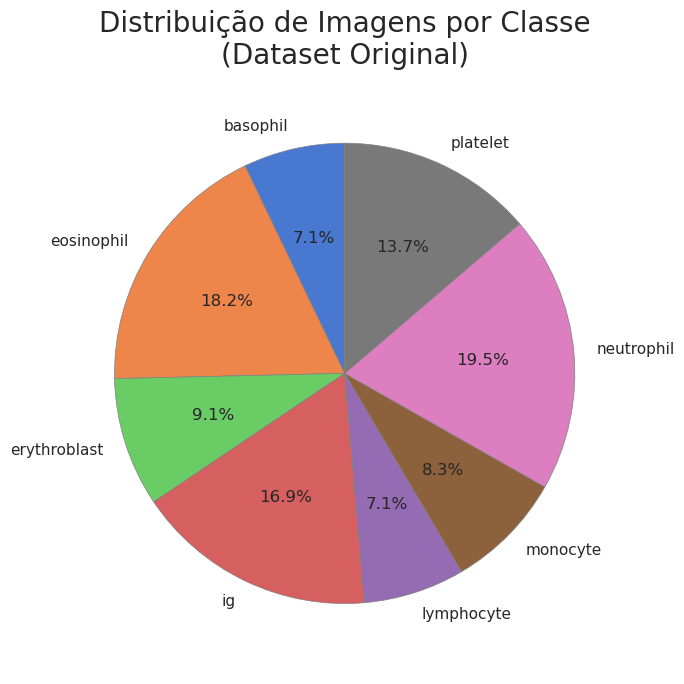


Contagem de imagens por classe:
- basophil: 1218
- eosinophil: 3117
- erythroblast: 1551
- ig: 2895
- lymphocyte: 1214
- monocyte: 1420
- neutrophil: 3329
- platelet: 2348


In [ ]:
image_counts = [len(os.listdir(os.path.join('bloodcells_dataset', class_name))) for class_name in class_names]

plt.figure(figsize=(7, 7))
sns.set_theme(style="darkgrid", palette="muted")
colors = sns.color_palette(n_colors=len(image_counts))
plt.pie(image_counts,
        labels=class_names,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'grey', 'linewidth': 0.5}
        )
plt.title('Distribuição de Imagens por Classe\n(Dataset Original)', fontdict={'fontsize': 20})
plt.axis('equal')
plt.tight_layout()
plt.show()
      
print("\nContagem de imagens por classe:")
for name, count in zip(class_names, image_counts):
    print(f"- {name}: {count}")

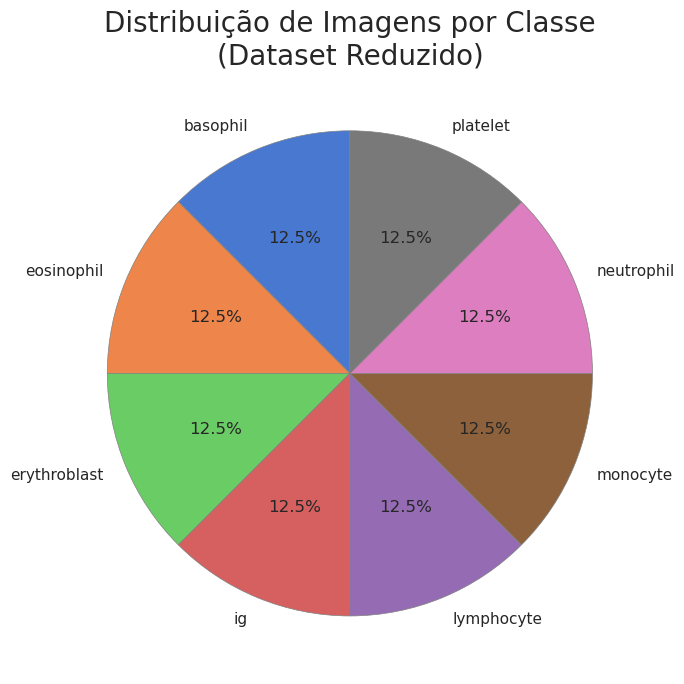


Contagem de imagens por classe:
- basophil: 500
- eosinophil: 500
- erythroblast: 500
- ig: 500
- lymphocyte: 500
- monocyte: 500
- neutrophil: 500
- platelet: 500


In [46]:
# Conta o número de arquivos em cada classe
image_counts = [len(os.listdir(os.path.join(input_folder, class_name))) for class_name in class_names]

plt.figure(figsize=(7, 7))
sns.set_theme(style="darkgrid", palette="muted")
colors = sns.color_palette(n_colors=len(image_counts))
plt.pie(image_counts,
        labels=class_names,
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        wedgeprops={'edgecolor': 'grey', 'linewidth': 0.5}
        )
plt.title('Distribuição de Imagens por Classe\n(Dataset Reduzido)', fontdict={'fontsize': 20})
plt.axis('equal')
plt.tight_layout()
plt.show()
      
print("\nContagem de imagens por classe:")
for name, count in zip(class_names, image_counts):
    print(f"- {name}: {count}")

In [ ]:
# Cria as pastas test, train e val no image_recognition
# split_ratio = (0.8, 0.1, 0.1)
# splitfolders.ratio(
#     input_folder,
#     output=output_folder,
#     seed=42,
#     ratio=split_ratio,
#     group_prefix=None
# )


Copying files: 4000 files [00:00, 10595.28 files/s]


In [ ]:
# Parâmetros
img_size = (360, 360)
batch_size = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,    # ResNet50
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
# Data augmentation for test data (only rescaling)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Data augmentation for validation data (only rescaling)
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [49]:
train_dir = os.path.join(output_folder, 'train')
test_dir = os.path.join(output_folder, 'test')
valid_dir = os.path.join(output_folder, 'val')

In [ ]:
# O método .flow_from_directory() lê os dados direto do diretório,
# alimentando o modelo de forma eficiente seguindo as especificações.

train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False # Evita inconsistência na predição
)

valid_data = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 3200 images belonging to 8 classes.
Found 400 images belonging to 8 classes.
Found 400 images belonging to 8 classes.


In [ ]:
# Pega um lote de imagens e labels
images, labels = next(valid_data)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..131.32].


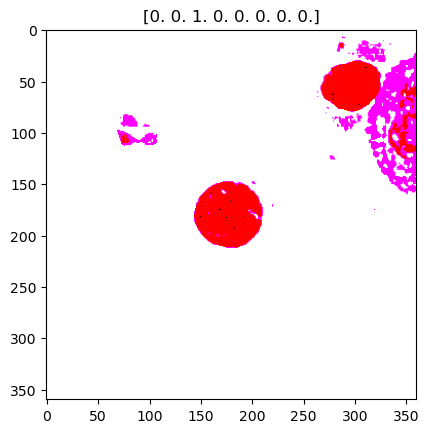

In [ ]:
# Seleciona uma imagem aleatória do lote
idx =  random.randint(0, images.shape[0] - 1)
plt.imshow(images[idx])
plt.title(labels[idx])
plt.show()

## Configurando o Modelo

In [ ]:
from keras.applications.resnet50 import ResNet50
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(img_size[0], img_size[1], 3))

# Congelando todos os pesos das 50 camadas do base_model
# durante o processo de treinamento
base_model.trainable = False

In [52]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    #layers.Dropout(0.5),
    layers.Dense(8, activation='softmax')
])

In [53]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 12, 12, 2048)   │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
# Rodar apenas se tiver o treinamento já carregado
# model.load_weights('/content/drive/MyDrive/IA/bloodcells_image_recognition/CropModel.keras')
# model.load_weights('CropModel.keras')

In [54]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Treinamento e Validação

In [55]:
# Rodar apenas ao treinar o algoritmo
history = model.fit(train_data, epochs=10, validation_data=valid_data)

/home/paulo/Programas/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 317s 3s/step - accuracy: 0.3988 - loss: 1.7352 - val_accuracy: 0.7125 - val_loss: 0.8139
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 314s 3s/step - accuracy: 0.7651 - loss: 0.7300 - val_accuracy: 0.8125 - val_loss: 0.5185
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 315s 3s/step - accuracy: 0.8528 - loss: 0.4698 - val_accuracy: 0.8125 - val_loss: 0.5174
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 313s 3s/step - accuracy: 0.8655 - loss: 0.4195 - val_accuracy: 0.8325 - val_loss: 0.4518
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.8921 - loss: 0.3190 - val_accuracy: 0.8975 - val_loss: 0.2969
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.8971 - loss: 0.3260 - val_accuracy: 0.8625 - val_loss: 0.3586
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 337s 3s/step - accuracy: 0.9065 - loss: 0.2805 - val_accuracy: 0.9100 - val_loss: 0.2762
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.9150 - loss: 0.2593 - val_accu

In [11]:
# Salva o histórico do treinamento
# df_history = pd.DataFrame(history.history)
# df_history.to_csv('training_history_sequential128_without_dropout.csv', index_label='epoch') # index_label para nomear a coluna do índice (épocas)

# Carrega o histórico da rede neural previamente treinada
df_loaded_history = pd.read_csv('training_history_sequential128_without_dropout.csv', index_col='epoch')
# Para converter de volta para um dicionário similar ao original (se necessário):
history = df_loaded_history.to_dict(orient='list')

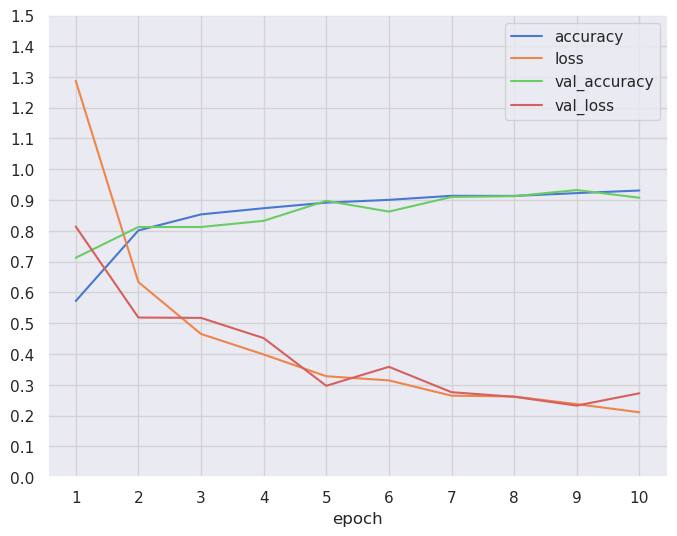

In [62]:
pd.DataFrame(history.history).plot(figsize=(8, 6))
plt.grid(True, color='lightgray', linestyle='-')
plt.gca().set_ylim(0, 1.25) # set the vertical range to [0-1]
plt.xticks([x for x in range(len(history.history['accuracy']))], labels=range(1,11))
plt.yticks([y/10 for y in range(16)])
plt.xlabel('epoch')
plt.show()

In [ ]:
# Validação do modelo com test_data
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Test loss: {test_loss * 100:.2f}%')

/home/paulo/Programas/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step - accuracy: 0.9302 - loss: 0.2330
Test accuracy: 93.50%
Test loss: 21.74%


In [152]:
def predict_img(image,model):
    test_img=cv2.imread(image)
    test_img=cv2.resize(test_img, img_size)
    test_img=np.expand_dims(test_img, axis=0)
    result=model.predict(test_img)
    r=np.argmax(result)
    print(class_names[r])

In [58]:
predict_img('image_recognition/train/ig/MMY_21284.jpg', model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 969ms/step
ig


In [ ]:
# Fazer previsões no conjunto de teste
num_test_samples = test_data.samples

# Se test_data.batch_size foi alterado para predição, 
# use esse valor, senão use o batch_size original

# Y_pred_probs conterá as probabilidades para cada classe
Y_pred_probs = model.predict(test_data, 
                             steps=int(np.ceil(num_test_samples / test_data.batch_size)))

# Y_pred conterá a classe predita (o índice da classe com maior probabilidade)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# Como definimos shuffle=False para test_data, test_data.classes 
# nos dará os rótulos na ordem correta
Y_true = test_data.classes

target_names = [class_names[i] for i in range(len(class_names))]

13/13 ━━━━━━━━━━━━━━━━━━━━ 39s 3s/step


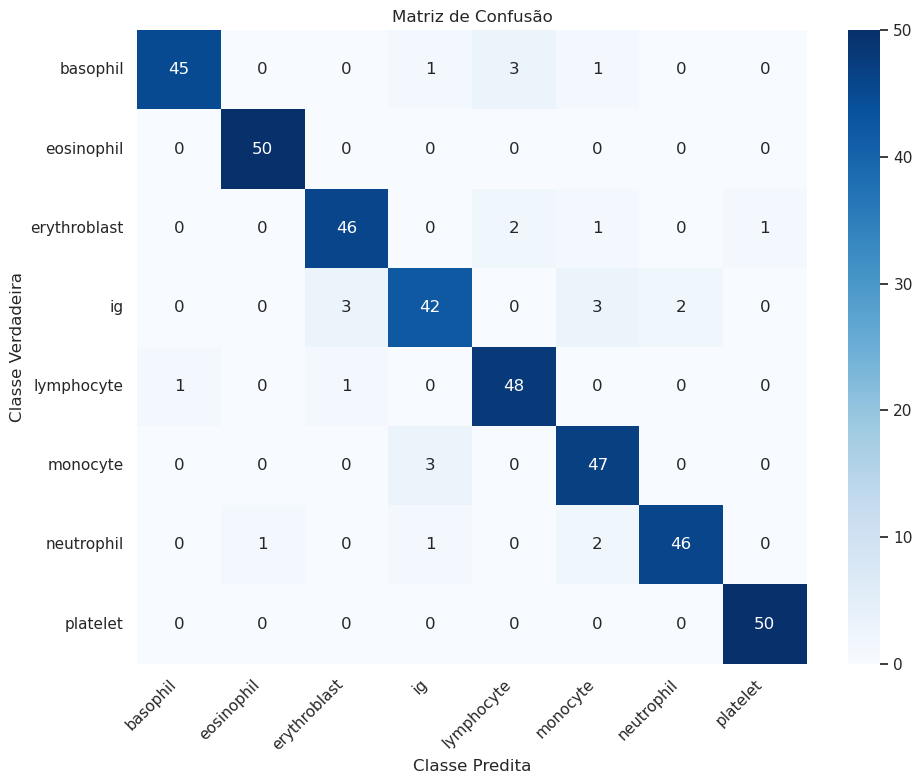


Relatório de Classificação:
              precision    recall  f1-score   support

    basophil       0.98      0.90      0.94        50
  eosinophil       0.98      1.00      0.99        50
erythroblast       0.92      0.92      0.92        50
          ig       0.89      0.84      0.87        50
  lymphocyte       0.91      0.96      0.93        50
    monocyte       0.87      0.94      0.90        50
  neutrophil       0.96      0.92      0.94        50
    platelet       0.98      1.00      0.99        50

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.93       400
weighted avg       0.94      0.94      0.93       400



In [ ]:
cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.title('Matriz de Confusão')
plt.ylabel('Classe Verdadeira')
plt.xlabel('Classe Predita')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Ajusta o layout para evitar que os rótulos se sobreponham
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(Y_true, Y_pred, target_names=target_names))


Iniciando análise t-SNE...
Criando extrator de features com a API Funcional...
Extraindo features para o t-SNE do conjunto de teste...
13/13 ━━━━━━━━━━━━━━━━━━━━ 36s 3s/step
Shape das features extraídas: (400, 128)
Shape dos rótulos: (400,)
Aplicando t-SNE...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.006s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 3.625896


/home/paulo/Programas/anaconda3/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.114285
[t-SNE] KL divergence after 1000 iterations: 0.532348
Shape dos resultados do t-SNE: (400, 2)


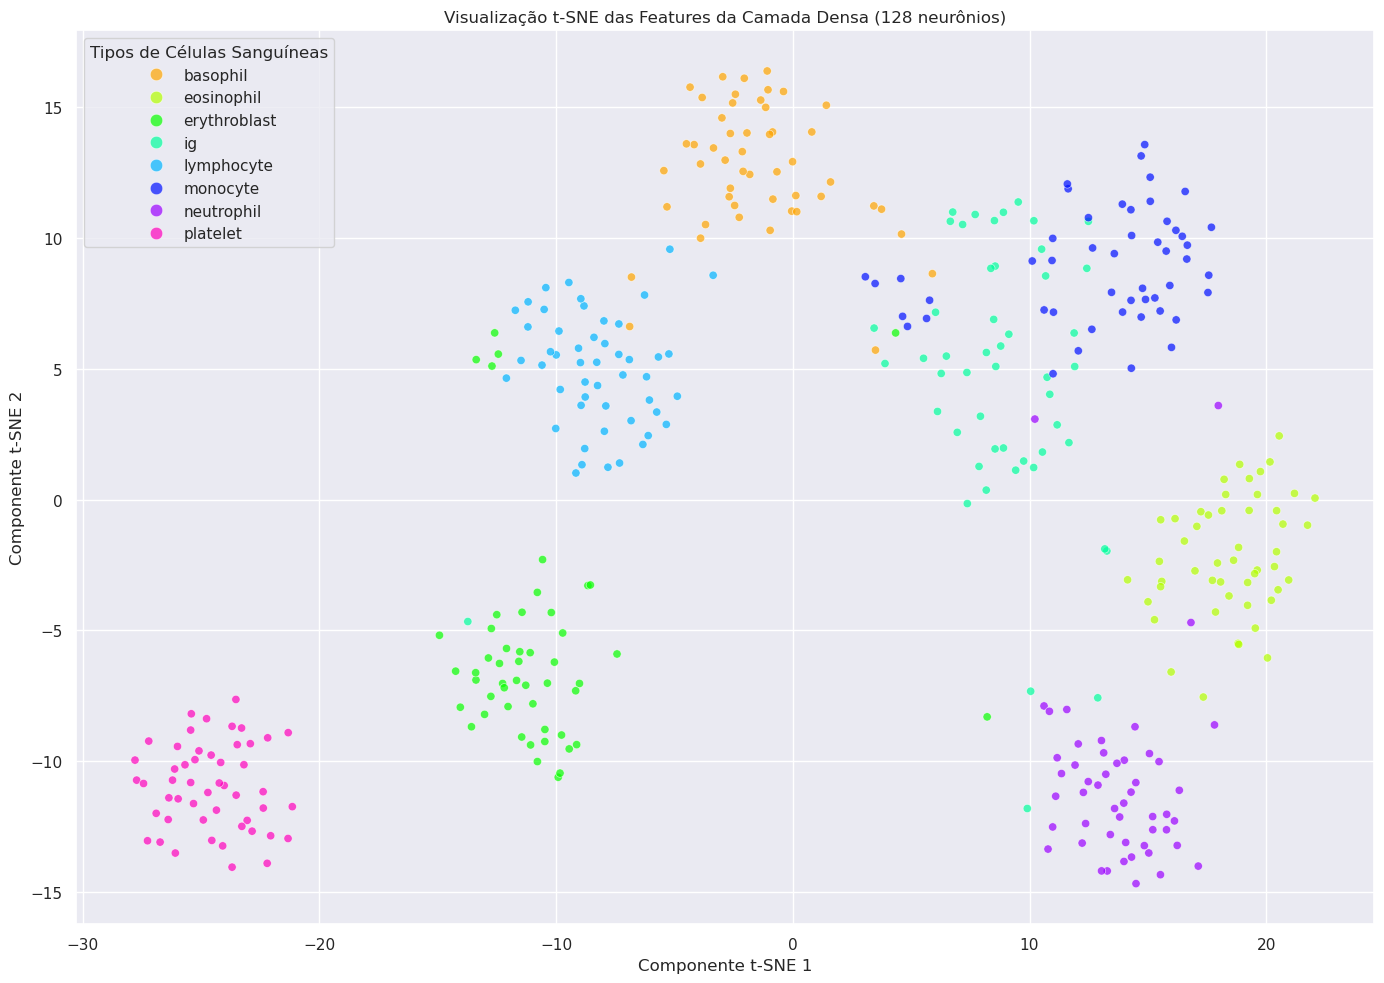

Análise t-SNE concluída.


In [ ]:
from sklearn.manifold import TSNE

print("\nIniciando análise t-SNE...")

# Criar um modelo para extrair features da camada 'dense' usando a API Funcional
print("Criando extrator de features com a API Funcional...")

# Define um novo tensor de entrada com o shape esperado pelo modelo
new_input = tf.keras.Input(shape=(img_size[0], img_size[1], 3), name="tsne_input")

# Pega as camadas do modelo original 'model'
# model.layers[0] é o base_model
# model.layers[1] é GlobalAveragePooling2D
# model.layers[2] é a camada Dense(128, activation='relu') que você nomeou como 'dense'

# Passa o novo tensor de entrada pelas camadas relevantes
x = model.layers[0](new_input)  # Passa pela base_model (ResNet50)
x = model.layers[1](x)          # Passa pela GlobalAveragePooling2D
dense_layer_output = model.layers[2](x) # Saída da camada 'dense' (Dense(128))

# Cria o modelo extrator de features
feature_extractor_model = models.Model(inputs=new_input, 
                                       outputs=dense_layer_output)


# Extrair features do conjunto de teste
# Reutilizamos test_data e Y_true que já foram definidos anteriormente no notebook
print("Extraindo features para o t-SNE do conjunto de teste...")
features = feature_extractor_model.predict(test_data, 
                                           steps=int(np.ceil(num_test_samples / test_data.batch_size)),
                                           verbose=1)

# Y_true (test_data.classes) já contém os rótulos verdadeiros do conjunto de teste
labels_for_tsne = Y_true 

print(f"Shape das features extraídas: {features.shape}")
print(f"Shape dos rótulos: {labels_for_tsne.shape}")

# Aplicar o t-SNE
# Pode ser demorado para muitos dados. Considere usar um subconjunto se necessário.
# Parâmetros comuns: n_components=2 (para visualização 2D), random_state para reprodutibilidade.
# perplexity é um parâmetro importante; valores entre 5 e 50 são comuns.
# n_iter é o número de iterações.
print("Aplicando t-SNE...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000, verbose=1)
tsne_results = tsne.fit_transform(features)

print("Shape dos resultados do t-SNE:", tsne_results.shape)

# Visualizar os resultados do t-SNE
# class_names já está definido no seu notebook
# {0: 'basophil', 1: 'eosinophil', ..., 7:'platelet'}

# Criar um DataFrame para facilitar a plotagem
df_tsne = pd.DataFrame(tsne_results, columns=['tsne1', 'tsne2'])
df_tsne['label'] = labels_for_tsne
# Mapear os rótulos numéricos para os nomes das classes
df_tsne['class_name'] = df_tsne['label'].map(class_names)

plt.figure(figsize=(14, 10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class_name",
    palette=sns.color_palette("hsv", n_colors=len(class_names)), # Você pode escolher outras paletas
    data=df_tsne,
    legend="full",
    alpha=0.7 # Ajuste a transparência se os pontos estiverem muito sobrepostos
)
plt.title('Visualização t-SNE das Features da Camada Densa (128 neurônios)')
plt.xlabel('Componente t-SNE 1')
plt.ylabel('Componente t-SNE 2')
plt.legend(title='Tipos de Células Sanguíneas', loc='best', markerscale=1.5)
plt.tight_layout()
plt.show()

print("Análise t-SNE concluída.")

In [63]:
# Necessário rodar essa célula para salvar os pesos do treinamento
model.save('CropModel2.keras')